In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": "0.9"})
sns.set_context("poster")

from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from keras import backend as K

import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import np_utils

from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils

Using TensorFlow backend.


# Real  run

In [2]:
def create_dataset(dataset, look_back=1):

        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):

            #The target is always the next value. And the lookback are the previous prices
            a = dataset[i:(i+look_back), :]
            dataX.append(a)
            dataY.append(dataset[i + look_back, :][0])

        return np.array(dataX), np.array(dataY)

Train on 186 samples, validate on 63 samples
Epoch 1/250
186/186 [==============================] - 1s 7ms/step - loss: 0.0273 - val_loss: 0.0368
Epoch 2/250
186/186 [==============================] - 0s 1ms/step - loss: 0.0114 - val_loss: 0.0149
Epoch 3/250
186/186 [==============================] - 0s 956us/step - loss: 0.0087 - val_loss: 0.0243
Epoch 4/250
186/186 [==============================] - 0s 944us/step - loss: 0.0082 - val_loss: 0.0283
Epoch 5/250
186/186 [==============================] - 0s 926us/step - loss: 0.0082 - val_loss: 0.0230
Epoch 00005: early stopping
Train Score: 0.01 RMSE
Test Score: 0.07 RMSE


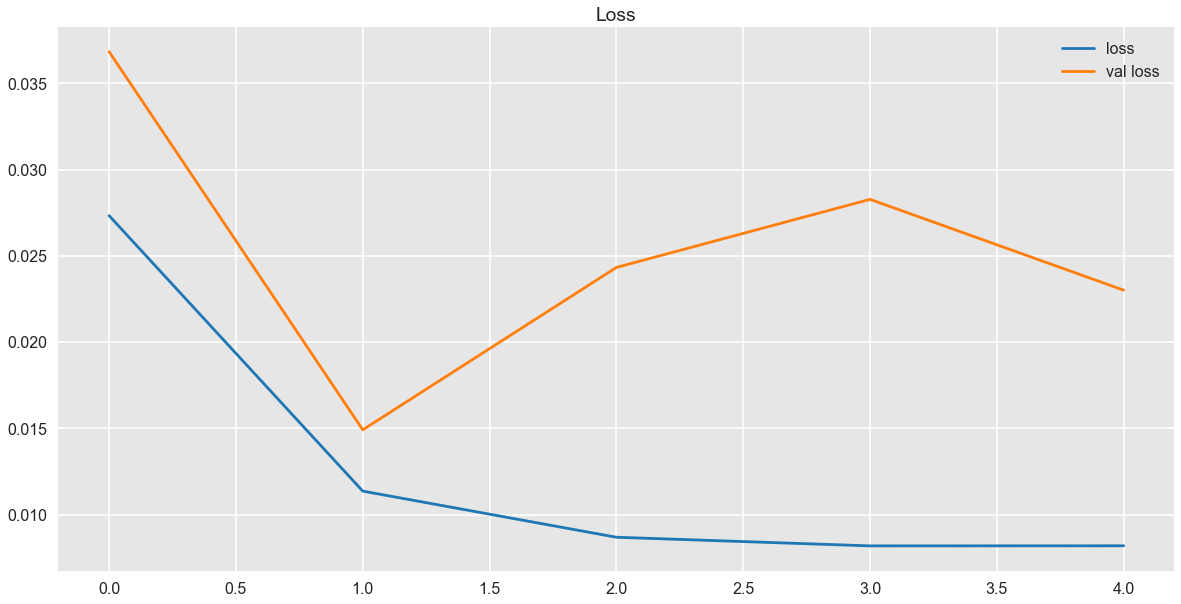

In [11]:
df = pd.read_csv('tweet_n_btc_day.csv')
#Drop np.nan
df.dropna(how='any', inplace=True)

#Make it array
df = df[['Weighted_Price']]
dataset = df.values
dataset = dataset.astype('float32')
    
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.70)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    
# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

#Define callbacks
callbacks = [

            keras.callbacks.EarlyStopping(monitor='loss',patience=3),
            keras.callbacks.ModelCheckpoint(filepath='forecasting_price_model.h5', monitor='val_loss',save_best_only=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=1),
            keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
        ]

# Define Model
model = Sequential()
model.add(LSTM(128, input_shape=(look_back, trainX.shape[2]),
                   dropout = 0.0409387396376823, recurrent_dropout=0.8378454352243405,return_sequences=True
                  ))
    
model.add(LSTM(128, dropout = 0.3815696341222277, recurrent_dropout= 0.4817115174045676))
model.add(Dense(512))

model.add(Dense(1))

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
    
model.compile(loss=root_mean_squared_error, optimizer='adam' )
history = model.fit(trainX, trainY, epochs=250, batch_size=16,callbacks=callbacks,validation_split=0.25,)
    
model.load_weights("forecasting_price_model.h5")
    
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[:], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
    
m_s_e = model.evaluate(testX, testY, verbose=0)

#plot also the loss function
plt.figure(figsize=(20,10))
plt.title('Loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

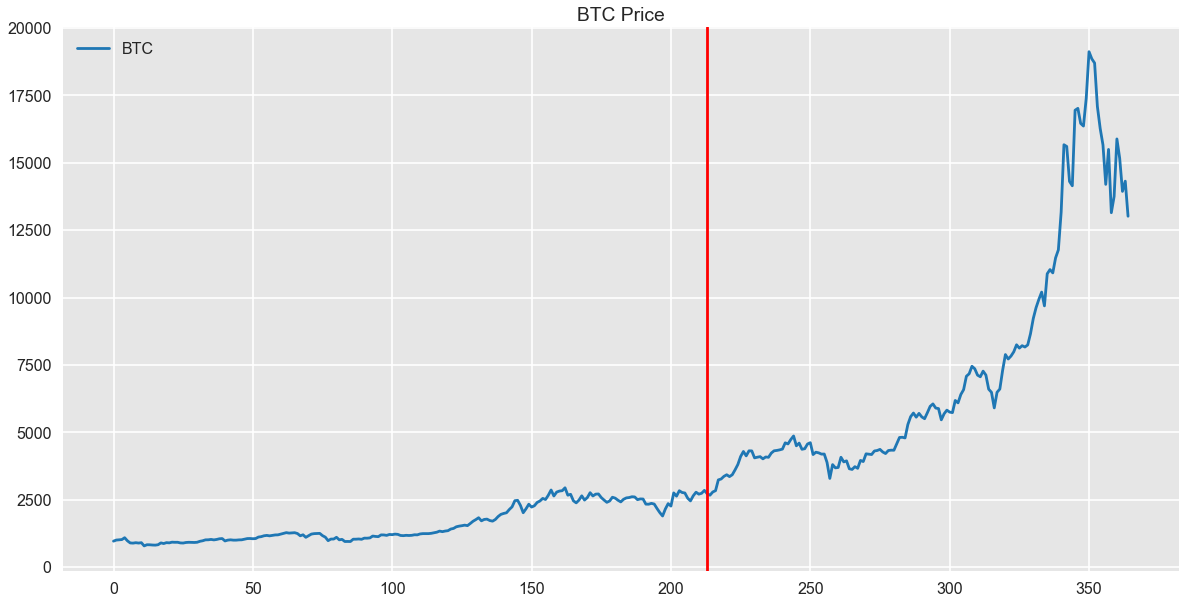

In [9]:
plt.figure(figsize=(20,10))
plt.title('BTC Price')
plt.plot(df['Weighted_Price'], label='BTC')
plt.axvline(x=213, color='r', linestyle='-')

plt.legend()
plt.show()

In [47]:
predictions = []

pred = model.predict(testX)
for i in range (len(pred)):
    if (pred[i][0] - pred[i-1][0] ) > 0 :
        predictions.append(1)
    else :
        predictions.append(0)

compare = []
for i in range (len(testY)):
    if (testY[i] - testY[i-1] ) > 0 :
        compare.append(1)
    else :
        compare.append(0)

In [48]:
from sklearn.metrics import accuracy_score
accuracy_score(predictions, compare)

0.5285714285714286